### Gender Breakdown in Irish Research Funding Bodies

Irish research funding bodies such as Science Foundation Ireland (SFI), the Irish Research Council (IRC) and the Health Research Board will [*"require higher education Institutions to have Athena SWAN Gender Equality accreditation in order to be eligible for research funding"*](http://www.sfi.ie/research-news/news/irish-funding-bodies-to-require-athena-swan-gender-equality-accreditation-for-higher-education-institutions/). In a major national initiative supported by the Higher Education Authority, the Athena SWAN Charter was launched in Ireland in early 2015, where [*"figures published by the Higher Education Authority highlighted gender inequality as an issue for the sector"*](https://www.ecu.ac.uk/equality-charters/athena-swan/athena-swan-ireland/).

In light of this, it is interesting to take a took at existing datasets to get an idea of specific gender breakdown details. SFI previously provided a dataset that *["details STEM research and ancillary projects funded by Science Foundation Ireland since its foundation in 2000"](https://www.sfi.ie/about-us/governance/open-data/)*. This is a useful dataset for such an exercise, and is the focus of this exploratory analysis. It is envisaged that similar analysis will be performed with other available datasets.

#### (Some Python imports etc.)

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

mpl.rcParams["figure.figsize"] = [8.0, 5.0] # Default = [6.0, 4.0]

### SFI Data
In this analysis, the [CSV provided by SFI](https://www.sfi.ie/about-us/governance/open-data/Open-Data-to-30-11-2016-for-Publication-v2.csv) (accessed 2018-10-09 and 2018-11-12, no changes at latter date) has been used as the source dataset. SFI also provide a corresponding [Explanatory Note](https://www.sfi.ie/about-us/governance/open-data/Science-Foundation-Ireland-Grant-Commitments-Explanatory-Note.docx).

### Let's retrieve the data, take an initial look, and perform some preprocessing.

In [3]:
df=pd.read_csv("https://www.sfi.ie/about-us/governance/open-data/Open-Data-to-30-11-2016-for-Publication-v2.csv", parse_dates=["Start Date", "End Date"], date_parser=lambda x: pd.datetime.strptime(x, "%d/%m/%Y"), encoding="ISO-8859-1", thousands=",")
df.columns

Index(['Proposal ID', 'Programme Name', 'Lead Applicant', 'Research Body',
       'Title of Research', 'Start Date', 'End Date',
       ' Revised Total Commitment (including overhead) '],
      dtype='object')

### Each entry in the dataset corresponds to a particular grant, with the grant totals in the *"Revised Total Commitment (including overhead)"* column. 

From the [Explanatory Note](https://www.sfi.ie/about-us/governance/open-data/Science-Foundation-Ireland-Grant-Commitments-Explanatory-Note.docx): *"This is the total current value of the award (direct costs) plus overhead (a contribution to the host Research Body towards the indirect costs of hosting SFI-funded research programmes)."* 

### The first five totals 

#### *(first column is the row index)*

In [4]:
df[" Revised Total Commitment (including overhead) "].head()

0    523698.0
1    511997.0
2     82521.0
3    499376.0
4   -215973.0
Name:  Revised Total Commitment (including overhead) , dtype: float64

### The totals column contains negative values

From the [Explanatory Note](https://www.sfi.ie/about-us/governance/open-data/Science-Foundation-Ireland-Grant-Commitments-Explanatory-Note.docx): *"Awards with a Proposal ID suffixed with an “(N)” are reimbursements by a co-funding partner."* 

#### *(first column is the row index)*

In [5]:
df[df[" Revised Total Commitment (including overhead) "]<0][["Proposal ID", " Revised Total Commitment (including overhead) "]]

,Proposal ID,Revised Total Commitment (including overhead)
4,15/IA/3024 EPA(N),-215973.0
5,15/IA/3024 GSI(N),-215973.0
56,15/IA/3100 MI(N),-970075.0
81,15/IA/3028 MI(N),-854794.0
144,15/US/B3130(N),-345539.0
463,14/ICS/B3042(N),-983767.0
721,13/IA/1977(N),-667862.0
722,13/IA/2025(N),-566458.0


### One proposal has no total specified

In [6]:
df[df[" Revised Total Commitment (including overhead) "].isnull()][" Revised Total Commitment (including overhead) "]

4026   NaN
Name:  Revised Total Commitment (including overhead) , dtype: float64

### Let's create a new *rtotal* column for simplifying analysis later on

In [7]:
df["rtotal"]=df[" Revised Total Commitment (including overhead) "].fillna(0).astype(np.int32)

In [8]:
df.rtotal.head()

0    523698
1    511997
2     82521
3    499376
4   -215973
Name: rtotal, dtype: int32

### Later on, binned *rtotal* values are used. First, take a quick look at the distribution:

In [9]:
df[df.rtotal>0].rtotal.describe()

count    4.479000e+03
mean     5.358748e+05
std      2.183297e+06
min      4.200000e+02
25%      1.133400e+04
50%      1.277410e+05
75%      2.938535e+05
max      5.770669e+07
Name: rtotal, dtype: float64

### Create a new column that contains corresponding *rtotal* binned values.

An alternative set of bin intervals may be used. However, these are based on the skewed *rtotal* distribution and a manual inspection of the dataset. 

In [10]:
binstarts=[1000, 5000, 10000, 50000, 100000, 300000, 500000, 1000000, 3000000, 5000000, 10000000, 20000000, 80000000]
df["rtotal_bin"]=pd.cut(df.rtotal, binstarts).apply(lambda x:"{0}-{1}".format(x.left, x.right))

In [11]:
df[["rtotal", "rtotal_bin"]].head()

,rtotal,rtotal_bin
0,523698,500000-1000000
1,511997,500000-1000000
2,82521,50000-100000
3,499376,300000-500000
4,-215973,NaN


### At this point, the CSV was locally updated:
1. *rtotal* and *rtotal_bin* columns were persisted.
1. As the SFI data does not currently provide gender details of the applicants, a *Gender* column was added:
 * This was achieved by means of a manual verification of the unique first names of the *Lead Applicant* column. 
 * **As more than a thousand applicants are in the dataset, the column values are currently restricted to *Male* and *Female*. However, this could be extended as required.**
 * For the names where the gender was unclear, it was determined by checking publicly available data, e.g. university profiles, photos etc.   
 * In cases where the *Lead Applicant* was *"VP/Dean of Research..."*, the gender was either that of the *Lead Applicant* at the time, or that of the person mentioned in the *Title of Research* (if available).
 * **Note: the *Gender* column has been manually validated a number of times. However, it should be emphasised that this is a best effort at the time, where a small number of inaccuracies may still be present. Please let me know if you notice any of the latter.**

This updated `20181112_gender_Open-Data-to-30-11-2016-for-Publication-v2.csv` is used for the remainder of the analysis.

In [12]:
df=pd.read_csv("data/20181112/20181112_gender_Open-Data-to-30-11-2016-for-Publication-v2.csv", parse_dates=["Start Date", "End Date"], date_parser=lambda x: pd.datetime.strptime(x, "%d/%m/%Y"), encoding="ISO-8859-1", thousands=",", skiprows=4)
df.columns

Index(['Proposal ID', 'Programme Name', 'Lead Applicant', 'Research Body',
       'Title of Research', 'Start Date', 'End Date',
       ' Revised Total Commitment (including overhead) ', 'rtotal', 'Gender',
       'rtotal_bin'],
      dtype='object')

### Let's exclude the negative and empty totals

In [13]:
df=df[df.rtotal>0]
df.rtotal=df.rtotal.astype(np.int32)

In [14]:
df[df.rtotal<0].rtotal

Series([], Name: rtotal, dtype: int32)

In [15]:
df[df.rtotal.isnull()].rtotal

Series([], Name: rtotal, dtype: int32)

### First, let's take a look at *Gender* according to unique *Lead Applicant*

In [16]:
df.groupby(["Lead Applicant", "Gender"]).count().reset_index().groupby(["Gender"]).size()

Gender
Female     359
Male      1203
dtype: int64

### The total number of grants per gender

In [17]:
df.groupby("Gender").size()

Gender
Female     910
Male      3569
dtype: int64

### And the corresponding grant totals

In [18]:
df.groupby("Gender").rtotal.sum()

Gender
Female     304472335
Male      2095710849
Name: rtotal, dtype: int32

### Top 20 *Lead Applicants* according to aggregated grant totals 

#### *(first column is the row index)*

In [19]:
df.groupby(["Lead Applicant", "Gender"]).rtotal.agg(["sum","count"]).reset_index().sort_values(by="sum", ascending=False)[["Gender", "count", "sum"]].rename(index=str, columns={"sum": "Grant Total", "count": "Number of Grants"}).head(20)

,Gender,Number of Grants,Grant Total
476,Male,13,87844846
1104,Male,10,60052854
859,Female,7,56065961
994,Male,3,48676927
1516,Male,7,45550690
829,Male,13,45112314
3,Male,19,43833815
1002,Male,7,37230090
707,Male,14,37218131
1273,Male,6,36887404


### Next, the number of grants per month, plotting the cumulative total

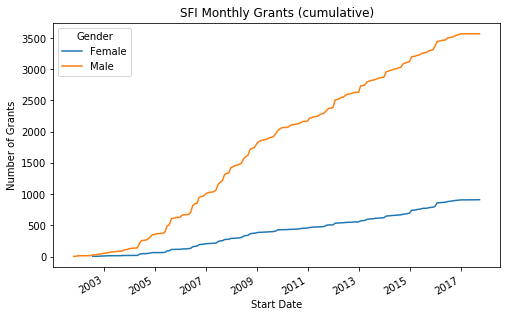

In [20]:
ax=df.groupby(["Gender", pd.Grouper(key="Start Date", freq="M")]).size().groupby(level=[0]).cumsum().unstack("Gender").fillna(method="ffill").plot(legend=True)
ax.set_ylabel("Number of Grants")
ax.set_title("SFI Monthly Grants (cumulative)");

### Next, the corresponding grant totals, plotting the cumulative total

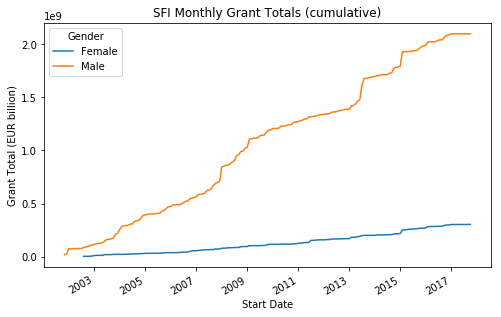

In [21]:
ax=df.groupby(["Gender", pd.Grouper(key="Start Date", freq="M")])["rtotal"].sum().groupby(level=[0]).cumsum().unstack("Gender").fillna(method="ffill").plot(legend=True)
ax.set_ylabel("Grant Total (EUR billion)")
ax.set_title("SFI Monthly Grant Totals (cumulative)");

### The dataset contains a *Research Body* column

From the [Explanatory Note](https://www.sfi.ie/about-us/governance/open-data/Science-Foundation-Ireland-Grant-Commitments-Explanatory-Note.docx): *"This relates to the University, Institute of Technology or other organisation to which the award was made or transferred."* 

In [22]:
df["Research Body"].head()

0    University College Dublin (UCD)
1       Trinity College Dublin (TCD)
2      University College Cork (UCC)
3    University College Dublin (UCD)
6        University of Limerick (UL)
Name: Research Body, dtype: object

### For now, let's focus on the universities, first looking at the number of grants per month

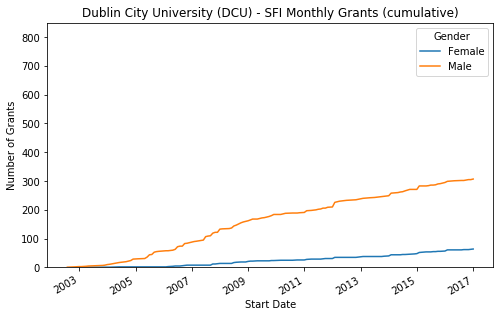

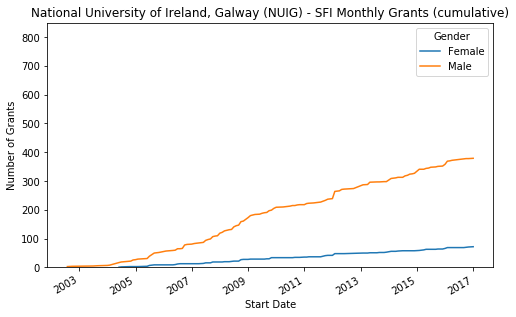

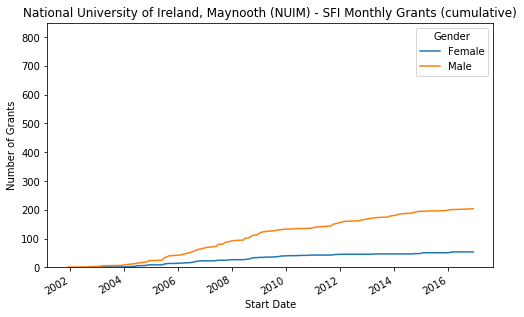

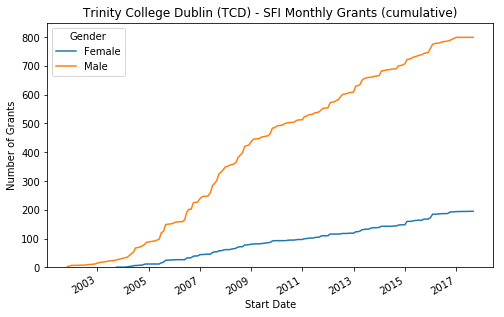

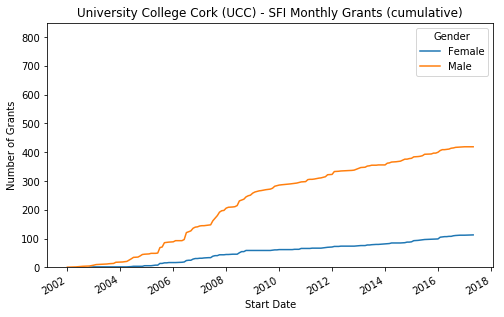

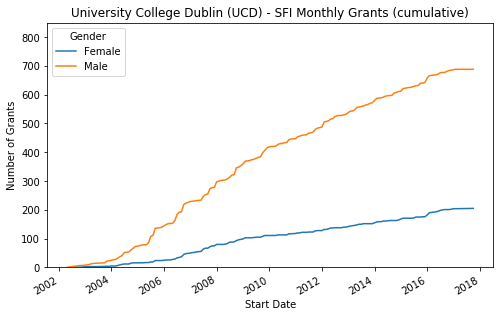

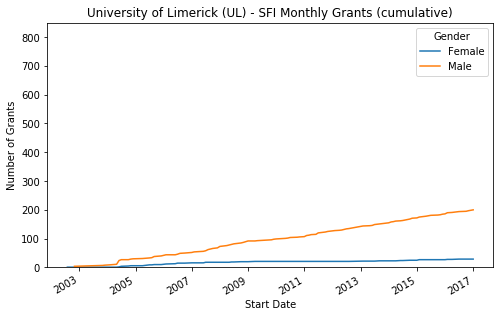

In [23]:
universities = [
          "Dublin City University (DCU)",
          "National University of Ireland, Galway (NUIG)",
          "National University of Ireland, Maynooth (NUIM)",
          "Trinity College Dublin (TCD)",
          "University College Cork (UCC)",
          "University College Dublin (UCD)",
          "University of Limerick (UL)",
          ]
for rb in universities:
    ax=df[df["Research Body"]==rb].groupby(["Gender", pd.Grouper(key="Start Date", freq="M")]).size().groupby(level=[0]).cumsum().unstack("Gender").fillna(method="ffill").plot(legend=True, ylim=(0,850))
    ax.set_ylabel("Number of Grants")
    ax.set_title("{0} - SFI Monthly Grants (cumulative)".format(rb));

### As before, the corresponding grant totals

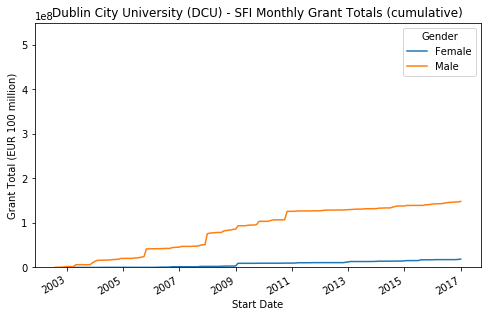

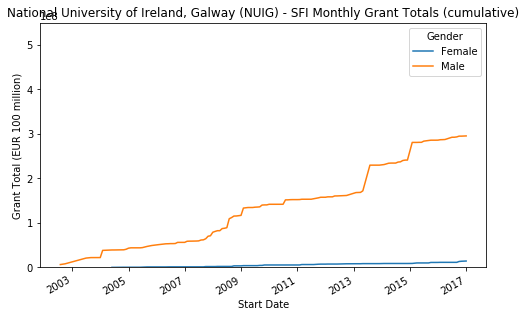

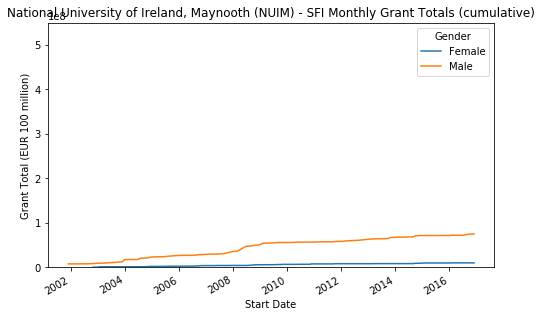

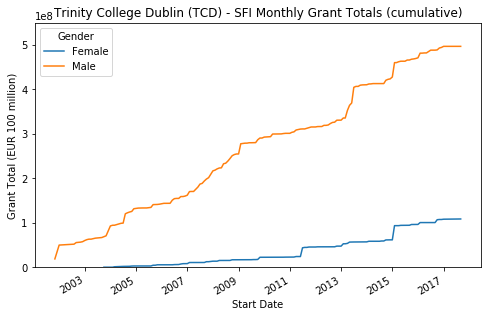

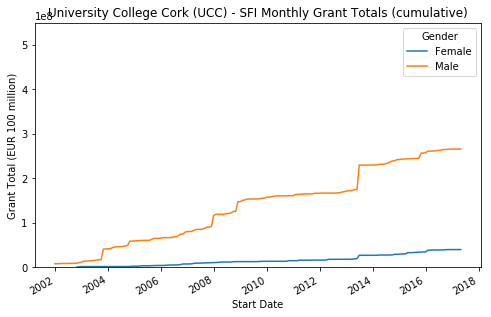

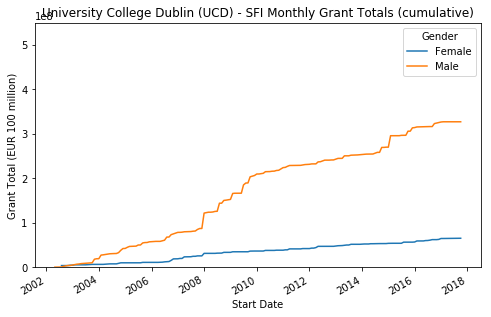

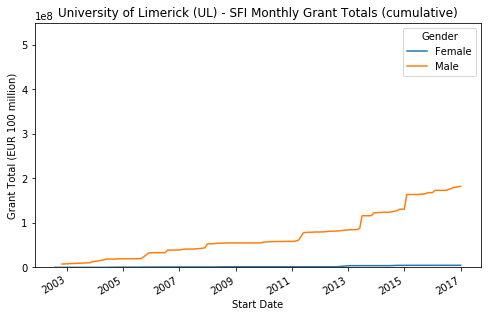

In [24]:
for rb in universities:
    ax=df[df["Research Body"]==rb].groupby(["Gender", pd.Grouper(key="Start Date", freq="M")])["rtotal"].sum().groupby(level=[0]).cumsum().unstack("Gender").fillna(method="ffill").plot(legend=True, title=rb, ylim=(0,5.5e8))
    ax.set_ylabel("Grant Total (EUR 100 million)")
    ax.set_title("{0} - SFI Monthly Grant Totals (cumulative)".format(rb));

### Next, the number of grants in each 6 month period (Apr/Oct)

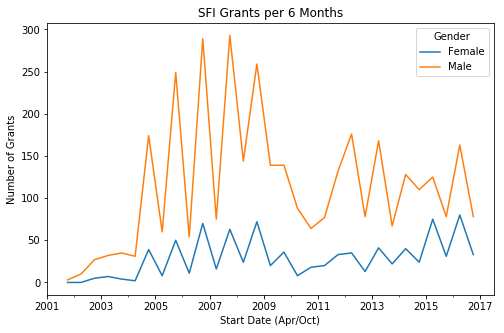

In [25]:
ax=df[df["Start Date"]<="2016-10-31"].groupby(["Gender", pd.Grouper(key="Start Date", freq="6M")]).size().unstack("Gender").fillna(0).plot(legend=True)
ax.set_ylabel("Number of Grants")
ax.set_xlabel("Start Date (Apr/Oct)");
ax.set_title("SFI Grants per 6 Months");

### And the corresponding grant totals

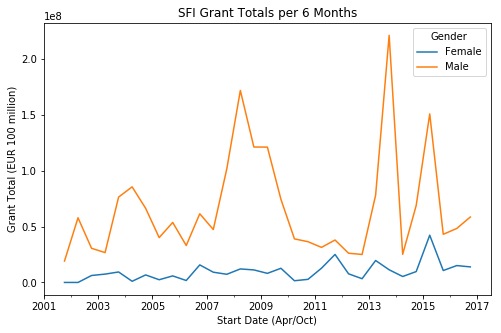

In [26]:
ax=df[df["Start Date"]<="2016-10-31"].groupby(["Gender", pd.Grouper(key="Start Date", freq="6M")]).rtotal.sum().unstack("Gender").fillna(0).plot(legend=True)
ax.set_ylabel("Grant Total (EUR 100 million)")
ax.set_xlabel("Start Date (Apr/Oct)");
ax.set_title("SFI Grant Totals per 6 Months");


### Let's look at the relationship between *Male* and *Female*, focusing on the number of monthly grants. 

Seaborn's [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) is used, which plots data and a corresponding linear regression model fit.

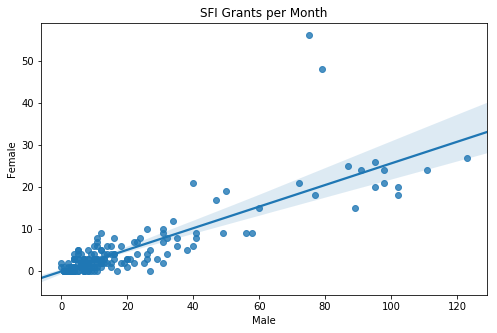

In [27]:
data=df[df["Start Date"]<="2016-10-31"].groupby(["Gender", pd.Grouper(key="Start Date", freq="1M")]).size().unstack("Gender").fillna(0)
ax=sns.regplot(x="Male", y="Female", data=data)
ax.set_title("SFI Grants per Month");

### Here's a linear model with more details, again using *Female* monthly grants as the dependent variable.

Statsmodels [Ordinary Least Squares](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) is used.

In [28]:
data=df[df["Start Date"]<="2016-10-31"].groupby(["Gender", pd.Grouper(key="Start Date", freq="1M")]).size().unstack("Gender").fillna(0)
mod = sm.OLS(data.Female, data.Male)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Female   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     643.8
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           1.07e-60
Time:                        10:15:35   Log-Likelihood:                -510.60
No. Observations:                 177   AIC:                             1023.
Df Residuals:                     176   BIC:                             1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Male           0.2555      0.010     25.374      0.000       0.236       0.275
==============================================================================
Omnibus:                      219.226   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10795.632
Skew:                           4.938   Prob(JB):                         0.00
Kurtosis:                      39.963   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### This can also be done for the corresponding monthly grant totals

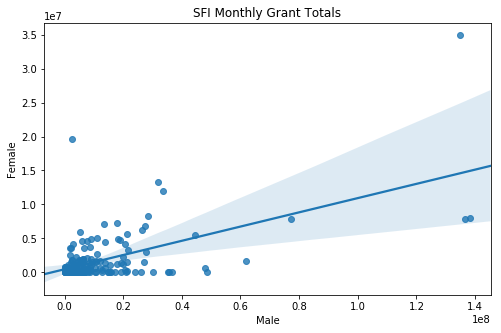

In [29]:
data=df[df["Start Date"]<="2016-10-31"].groupby(["Gender", pd.Grouper(key="Start Date", freq="1M")]).rtotal.sum().unstack("Gender").fillna(0)
ax=sns.regplot(x="Male", y="Female", data=data)
ax.set_title("SFI Monthly Grant Totals");

### As with monthly grants, here's a linear model with more details, using *Female* monthly grant totals as the dependent variable

In [30]:
data=df[df["Start Date"]<="2016-10-31"].groupby(["Gender", pd.Grouper(key="Start Date", freq="1M")]).rtotal.sum().unstack("Gender").fillna(0)
mod = sm.OLS(data.Female, data.Male)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Female   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     141.1
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           2.82e-24
Time:                        10:15:49   Log-Likelihood:                -2890.2
No. Observations:                 177   AIC:                             5782.
Df Residuals:                     176   BIC:                             5786.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Male           0.1146      0.010     11.879      0.000       0.096       0.134
==============================================================================
Omnibus:                      149.915   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2720.269
Skew:                           2.989   Prob(JB):                         0.00
Kurtosis:                      21.252   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### As mentioned earlier, the *rtotal_bin* column contains binned *rtotal* values. Let's look at the number of grants per bin.

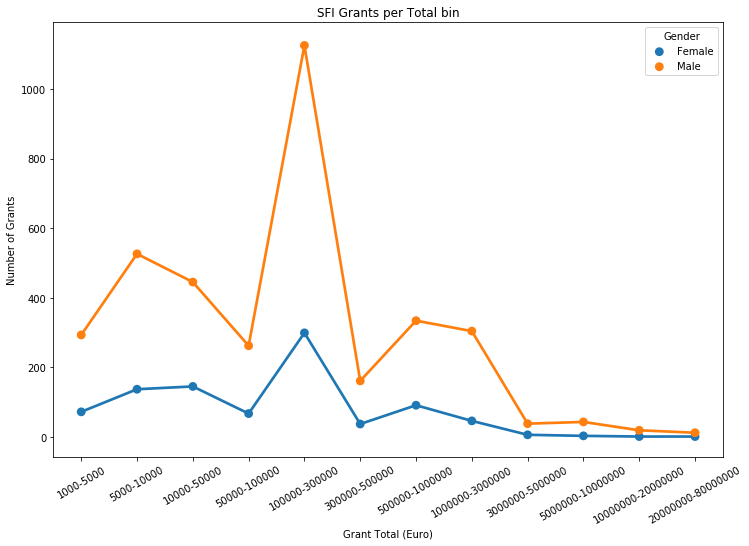

In [31]:
plt.figure(figsize=(12, 8))
bindf=df.groupby(["Gender", "rtotal_bin"]).size().reset_index()
bindf["binkey"]=bindf.rtotal_bin.apply(lambda x:int(x.split('-')[1]))
ax=sns.pointplot(x="rtotal_bin", y=0, hue="Gender", data=bindf.sort_values(by=["binkey", "Gender"]))
ax.set_xlabel("Grant Total (Euro)")
ax.set_ylabel("Number of Grants")
ax.set_title("SFI Grants per Total bin")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

### The SFI dataset contains a *Lead Applicant* column, where other people involved in the grant are not specified.

From the [Explanatory Note](https://www.sfi.ie/about-us/governance/open-data/Science-Foundation-Ireland-Grant-Commitments-Explanatory-Note.docx): *"The Lead Applicant is the person who holds and is responsible for the award. This is, in the vast majority of cases, the person who applied for and won the grant. However, in a small number of cases, the award may have been transferred to another researcher."* 

### However, further details may be found by looking at the [SFI Research Centres](http://sfi.ie/sfi-research-centres/). As each centre typically provides a website containing researcher profiles, a separate dataset was created:

* The researcher HTML pages were retrieved for each centre (accessed 2018-10-12, with a subset also accessed on 2018-11-12). 
* A *Centre*, *Name*, *Role*, *Gender* record was created for each researcher parsed from the HTML. *Role* values are typically provided in the HTML, while *Gender* was populated using the manual process described above.

Note:

* The *Role* values vary between centres, with certain roles not always specified. Consequently, the *Role* column has between restricted to the *Funded Investigator* -> *Director* roles (or similar). It can be assumed that each of these indicate potential candidates for *Lead Applicant* in the SFI dataset.
* As before, although it has undergone multiple validation iterations, the *Gender* column may contain inaccuracies.
* Specific HTML parsing details per centre are provided in the Appendix below.
* The [BEACON centre](http://www.beaconcentre.ie/) is not considered as the profile pages were not accessible on 2018-10-12 and 2018-11-12.
* Researchers listed on the [VistaMilk centre page](http://vistamilk.ie/home/people/) on 2018-11-12 who were not originally listed on 2018-10-12 have been added to the dataset.
* The generated `sficentres.csv` is used for the remainder of the analysis. For now, it has not been uploaded, but feel free to contact me if you have any related questions.
* **It is possible that certain researchers are missing from this derived dataset, for example, centre researchers who were not listed on the corresponding website pages on 2018-10-12 or 2018-11-12 (see Appendix below).**

### Let's load this data and take an initial look

In [32]:
centresdf=pd.read_csv("data/20181112/sficentres.csv")
centresdf.columns

Index(['Centre', 'Name', 'Role', 'Gender'], dtype='object')

In [33]:
centresdf.groupby(["Gender"]).size()

Gender
Female    113
Male      490
dtype: int64

### Next, the number of researchers per centre

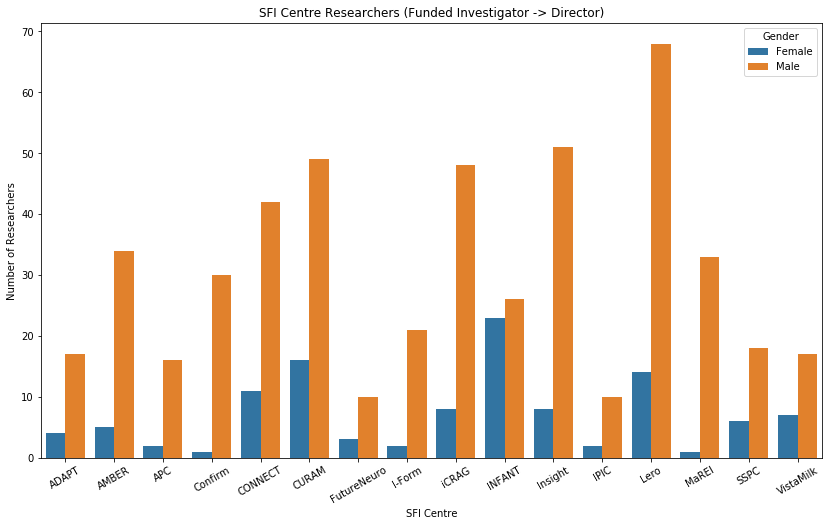

In [34]:
plt.figure(figsize=(14, 8))
plotdf=centresdf.groupby(["Centre", "Gender"]).size().reset_index()
plotdf["sortkey"]=plotdf.Centre.apply(lambda x:x.lower())
ax=sns.barplot(x="Centre", y=0, hue="Gender", data=plotdf.sort_values(by=["sortkey", "Gender"]))
ax.set_ylabel("Number of Researchers")
ax.set_xlabel("SFI Centre")
ax.set_title("SFI Centre Researchers (Funded Investigator -> Director)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

### For each centre, the number of researchers per role

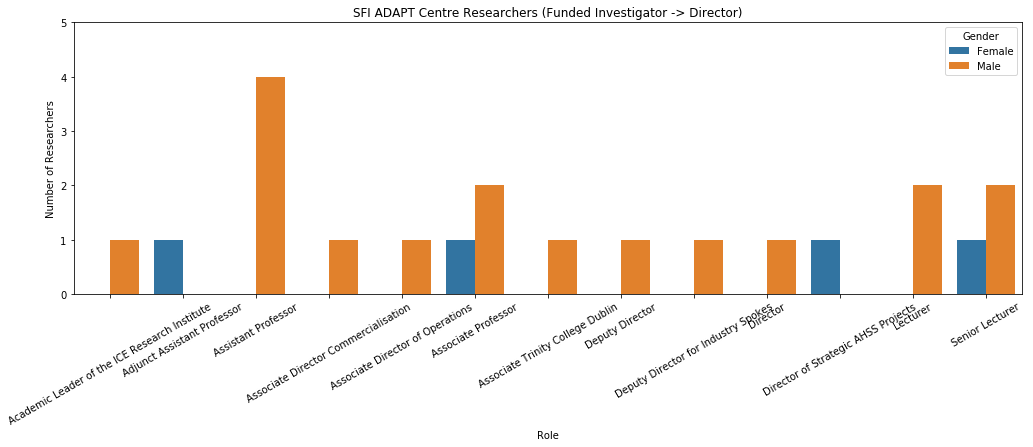

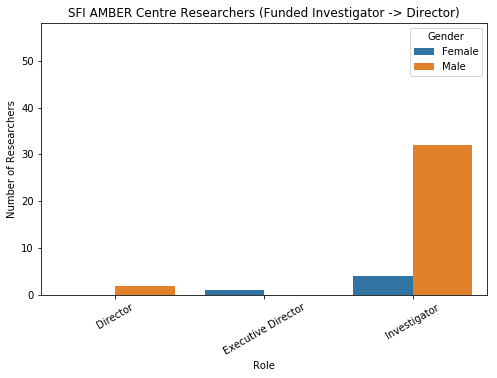

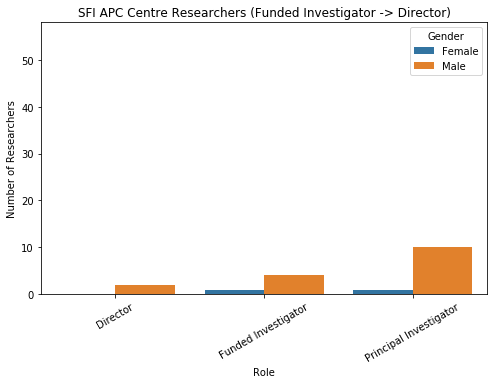

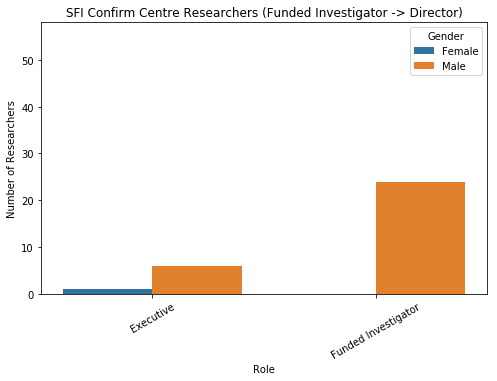

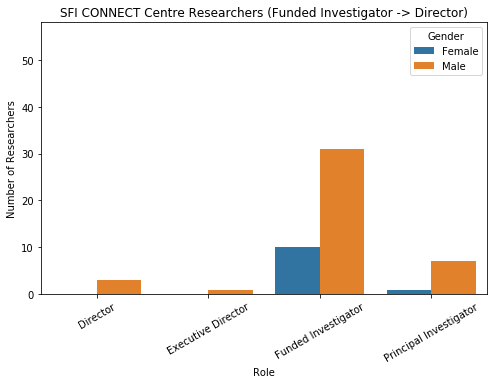

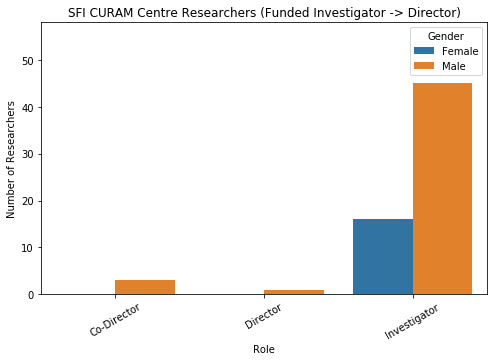

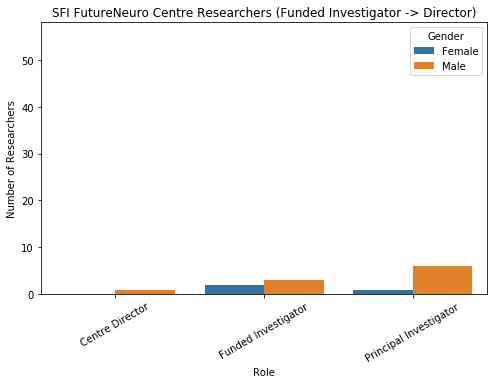

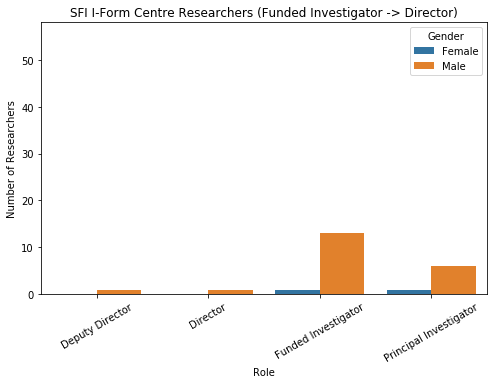

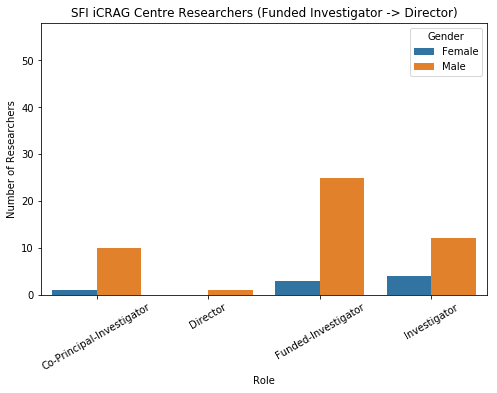

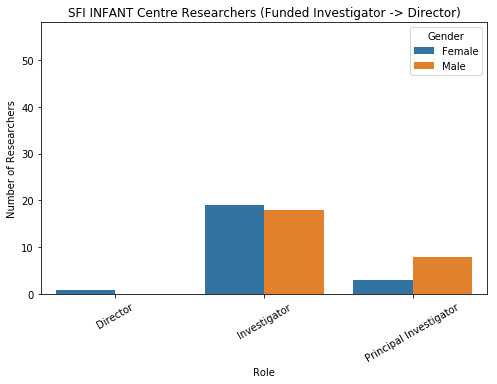

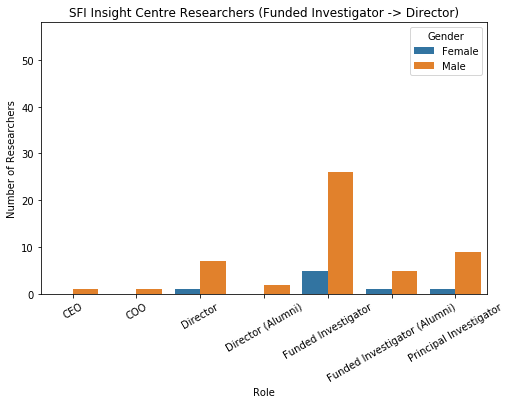

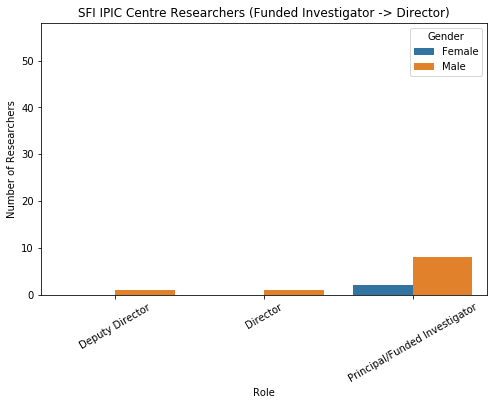

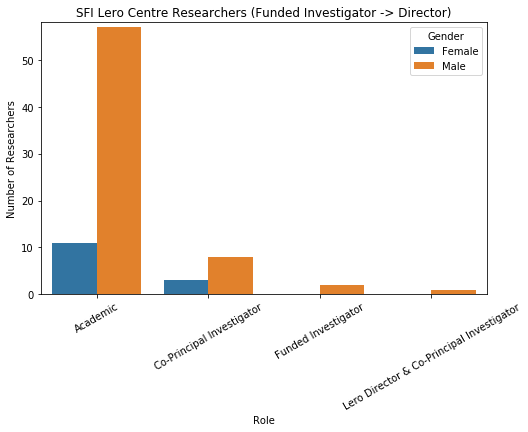

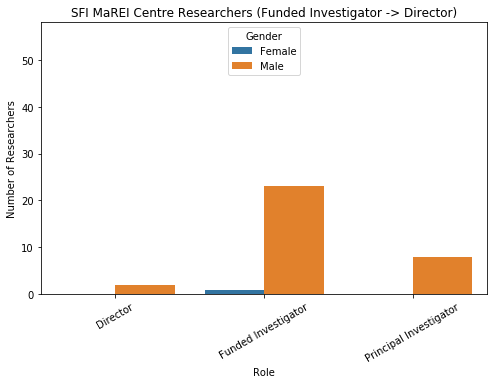

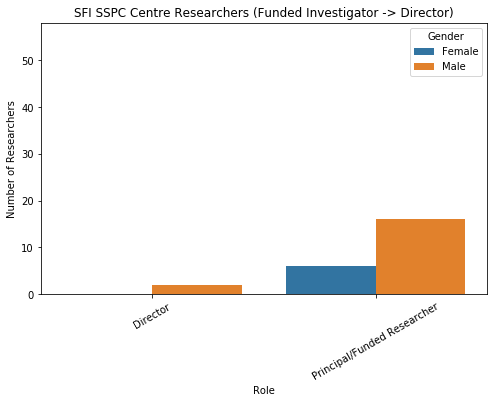

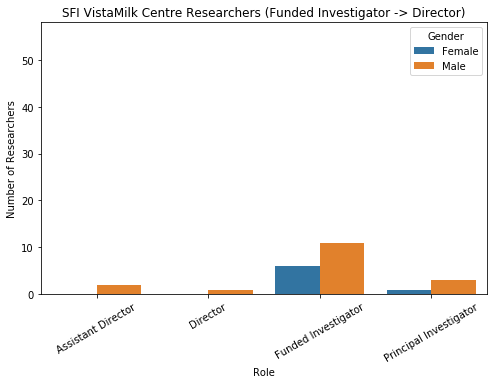

In [35]:
current_palette = sns.color_palette()
for centre in sorted(centresdf.Centre.unique(), key=lambda x:x.lower()):  
    if centre=="ADAPT":
        # ADAPT centre has many roles
        plt.figure(figsize=(17, 5))
    ax=sns.barplot(x="Role", 
                   y=0, 
                   hue="Gender", 
                   palette={"Female":current_palette[0], "Male":current_palette[1]}, 
                   hue_order=["Female", "Male"],
                   data=centresdf[centresdf.Centre==centre].groupby(["Role", "Gender"]).size().reset_index())
    ax.set_ylabel("Number of Researchers")
    ax.set_ylim((0,58))
    ax.set_title("SFI {0} Centre Researchers (Funded Investigator -> Director)".format(centre))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    if centre=="ADAPT":
        ax.set_ylim((0, 5))
    plt.show()

### Lets go back to the original SFI data, and look at the corresponding centre grants by means of the *Programme Name* column. 

### First, the *"SFI Research Centres"*

Note: 

* in the case of at least one centre, the current director (and gender) is different to the corresponding *Lead Applicant*.
* **Details for only 12 centres are provided in the SFI data.**

#### *(first column is the row index)*

In [36]:
df[df["Programme Name"]=="SFI Research Centres"][["Title of Research", "Start Date", "Gender", "rtotal"]].sort_values(by="rtotal", ascending=False)

,Title of Research,Start Date,Gender,rtotal
1062,INSIGHT - Irelands Big Data and Analytics Rese...,2013-07-01,Male,57706691
667,CÃRAM - Centre for Research in Medical Devices,2015-01-01,Male,37092901
1078,Alimentary Pharmabiotic Centre (APC) - Interfa...,2013-06-01,Male,35885432
1077,Advanced Materials and BioEngineering Research...,2013-06-01,Male,35171606
666,Lero - the Irish Software Research Centre,2015-01-01,Male,32604686
665,CONNECT: The Centre for Future Networks & Comm...,2015-01-01,Female,31147453
664,ADAPT: Centre for Digital Content Platform Res...,2015-01-01,Male,30713725
1076,Synthesis and Solid State Pharmaceutical Centr...,2013-06-01,Male,28131618
663,Irish Centre for Research in Applied Geoscienc...,2015-01-01,Male,24888554
1075,I-PIC Irish Photonic Integration Research Centre,2013-06-01,Male,19612064


### Next, the centre supplements

#### *(first column is the row index)*

In [37]:
df[df["Programme Name"]=="SFI Research Centres Supplement"][["Title of Research", "Start Date", "Gender", "rtotal"]].sort_values(by="rtotal", ascending=False)

,Title of Research,Start Date,Gender,rtotal
866,INSIGHT - Irelands Big Data and Analytics Rese...,2014-03-01,Male,1748614
435,Business Development/Industry Liaison Manager ...,2015-09-01,Female,1218484
859,Alimentary Pharmabiotic Centre (APC) - Interfa...,2014-03-01,Male,562307
860,Marine Renewable Energy Ireland (MaREI) - EU G...,2014-03-01,Male,562307
861,Synthesis and Solid State Pharmaceutical Centr...,2014-03-01,Male,562307
862,I-PIC Irish Photonic Integration Research Cent...,2014-03-01,Male,562307
863,Advanced Materials and BioEngineering Research...,2014-03-01,Male,562307
711,Irish Centre for Fetal and Neonatal Translatio...,2014-10-01,Female,358489
654,Alimentary Pharmabiotic Centre (APC) - Interfa...,2015-01-01,Male,260000
655,Synthesis and Solid State Pharmaceutical Centr...,2015-01-01,Male,260000


### The earliest centre *"Start Date"*

In [38]:
df[df["Programme Name"].isin(["SFI Research Centres", "SFI Research Centres Supplement"])]["Start Date"].sort_values(ascending=True).head(1)

1078   2013-06-01
Name: Start Date, dtype: datetime64[ns]

### Total grants for all centres

In [39]:
df[df["Programme Name"].isin(["SFI Research Centres", "SFI Research Centres Supplement"])].rtotal.sum()

368283304

### All other non-centre funding since the earliest centre *"Start Date"*

In [40]:
df[(df["Start Date"]>="2013-06-01") & (~df["Programme Name"].isin(["SFI Research Centres", "SFI Research Centres Supplement"]))].rtotal.sum()

365449344

### Continuing with the *Programme Name* column, let's look at the gender breakdown for all programmes, using aggregated grant totals

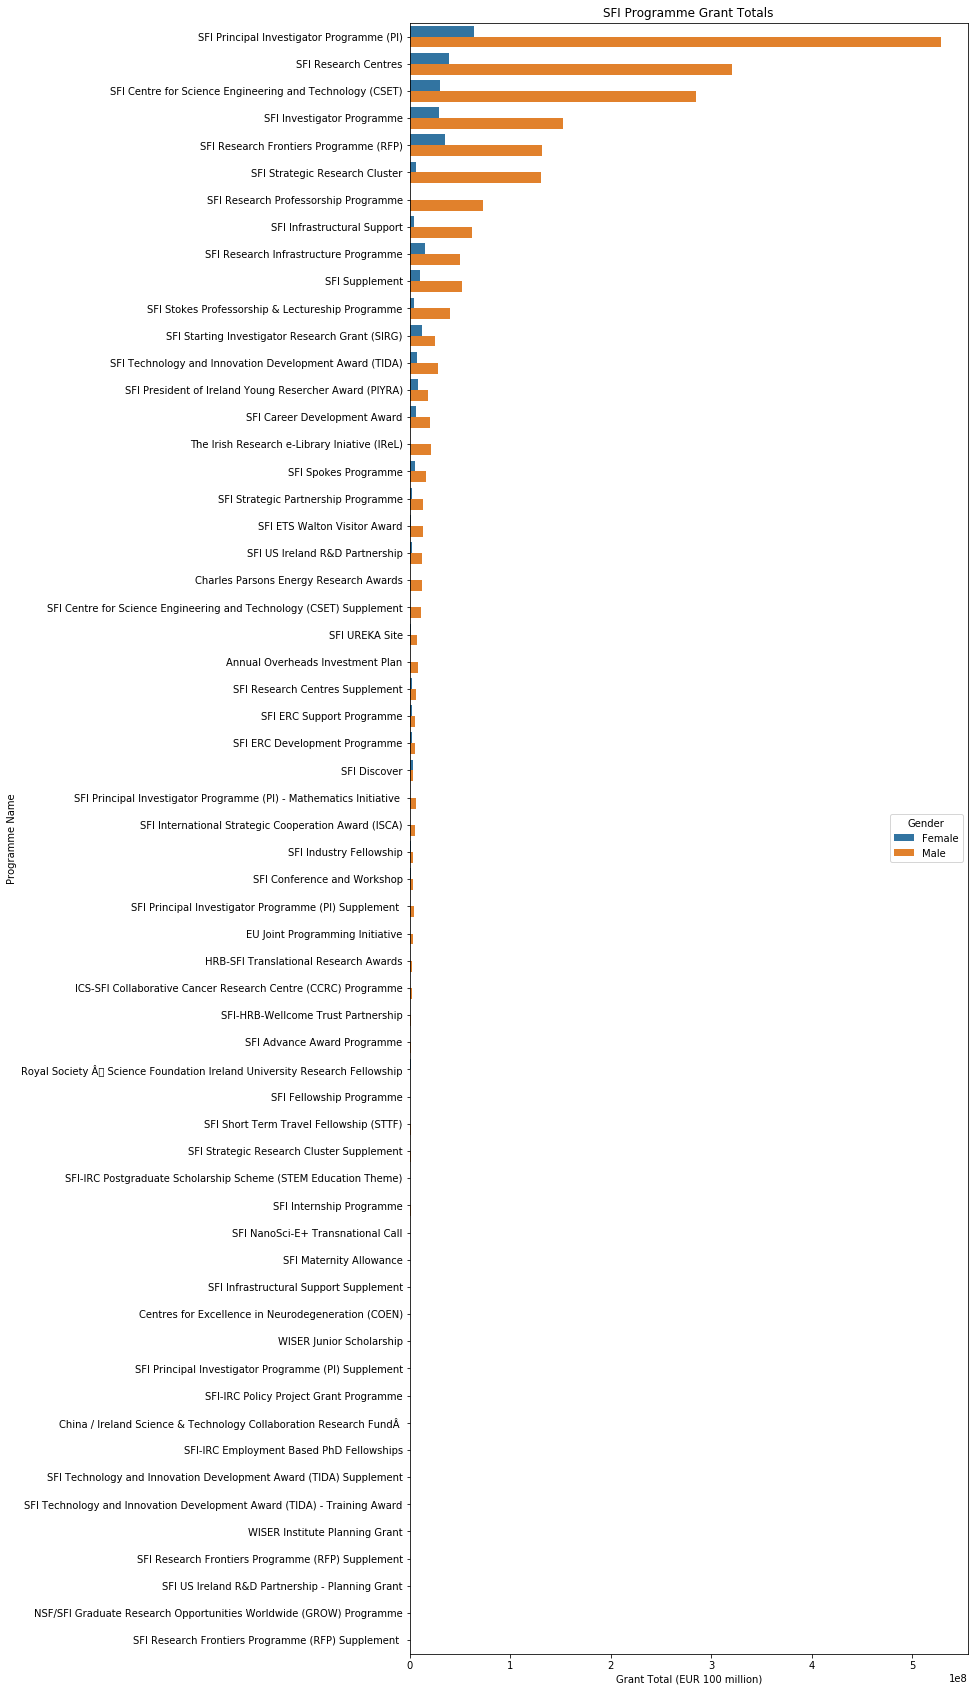

In [41]:
pndf=df.groupby(["Programme Name", "Gender"]).rtotal.sum().reset_index()
sorted_pn=pndf.groupby("Programme Name").rtotal.sum().reset_index().sort_values(by="rtotal", ascending=False).reset_index()[["Programme Name", "rtotal"]]
pndf["pnkey"]=pndf["Programme Name"].apply(lambda x:sorted_pn[sorted_pn["Programme Name"]==x].index[0])

plt.figure(figsize=(10,30))

ax=sns.barplot(x="rtotal", 
               y="Programme Name", 
               hue="Gender", 
               data=pndf.sort_values(by=["pnkey", "Gender"]))
ax.set_xlabel("Grant Total (EUR 100 million)")
ax.set_title("SFI Programme Grant Totals");
#plt.savefig('./sfi_programme_totals_all.png', bbox_inches="tight")

### Due to the skewed totals distribution, details for a significant number of programmes are unclear. Let's look more closely, first focusing on programmes having aggregated totals greater than EUR 30 million

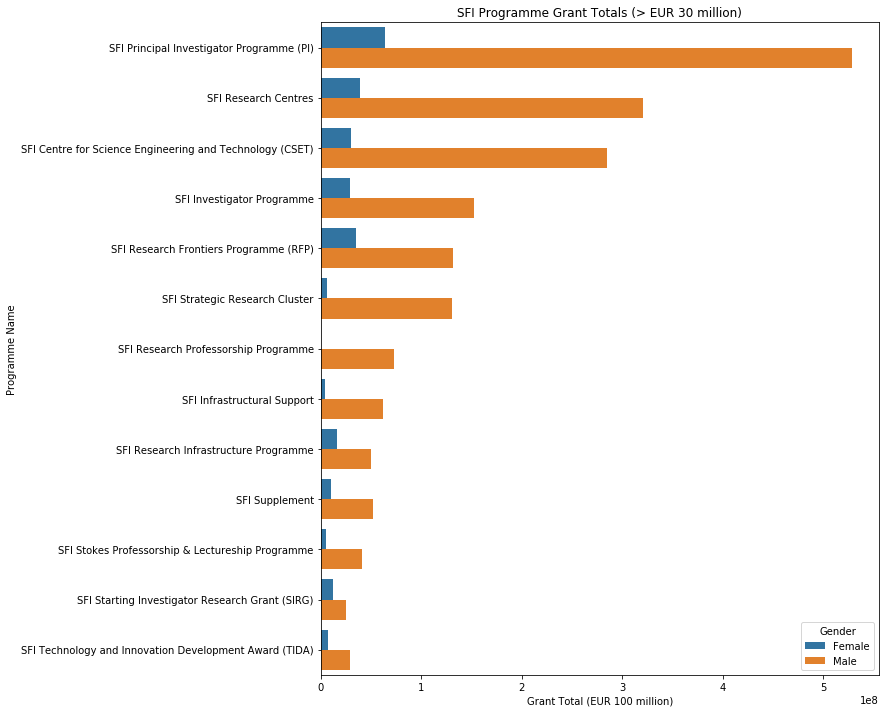

In [42]:
plt.figure(figsize=(10,12))

ax=sns.barplot(x="rtotal", 
               y="Programme Name", 
               hue="Gender", 
               data=pndf[pndf["Programme Name"].isin(sorted_pn[sorted_pn.rtotal>30e6]["Programme Name"])].sort_values(by=["pnkey", "Gender"]))
ax.set_xlabel("Grant Total (EUR 100 million)")
ax.set_title("SFI Programme Grant Totals (> EUR 30 million)");
#plt.savefig('./sfi_programme_totals_gt30m.png', bbox_inches="tight")

### Next, programmes having aggregated totals between EUR 10 million and EUR 30 million

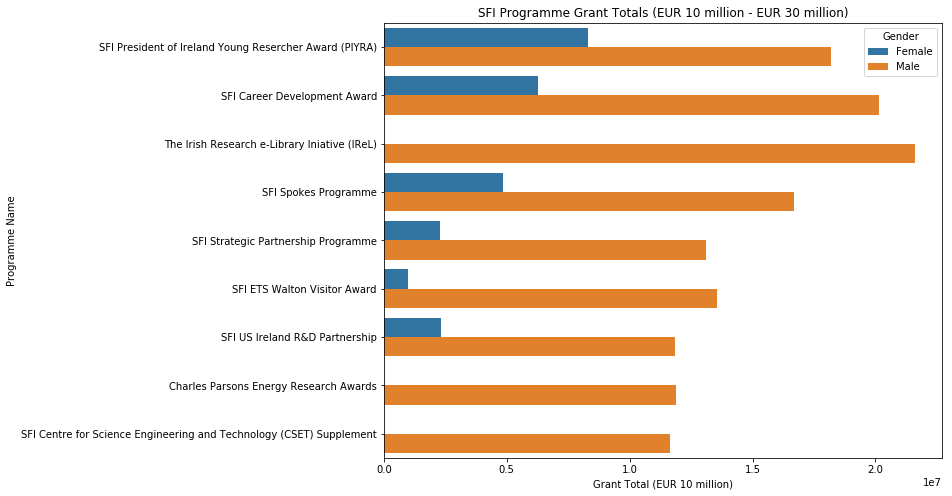

In [43]:
plt.figure(figsize=(10,8))

ax=sns.barplot(x="rtotal", 
               y="Programme Name", 
               hue="Gender", 
               data=pndf[pndf["Programme Name"].isin(sorted_pn[(sorted_pn.rtotal>10e6) & (sorted_pn.rtotal<=30e6)]["Programme Name"])].sort_values(by=["pnkey", "Gender"]))
ax.set_xlabel("Grant Total (EUR 10 million)")
ax.set_title("SFI Programme Grant Totals (EUR 10 million - EUR 30 million)");
#plt.savefig('./sfi_programme_totals_10m_30m.png', bbox_inches="tight")

### Next, programmes having aggregated totals between EUR 1 million and EUR 10 million

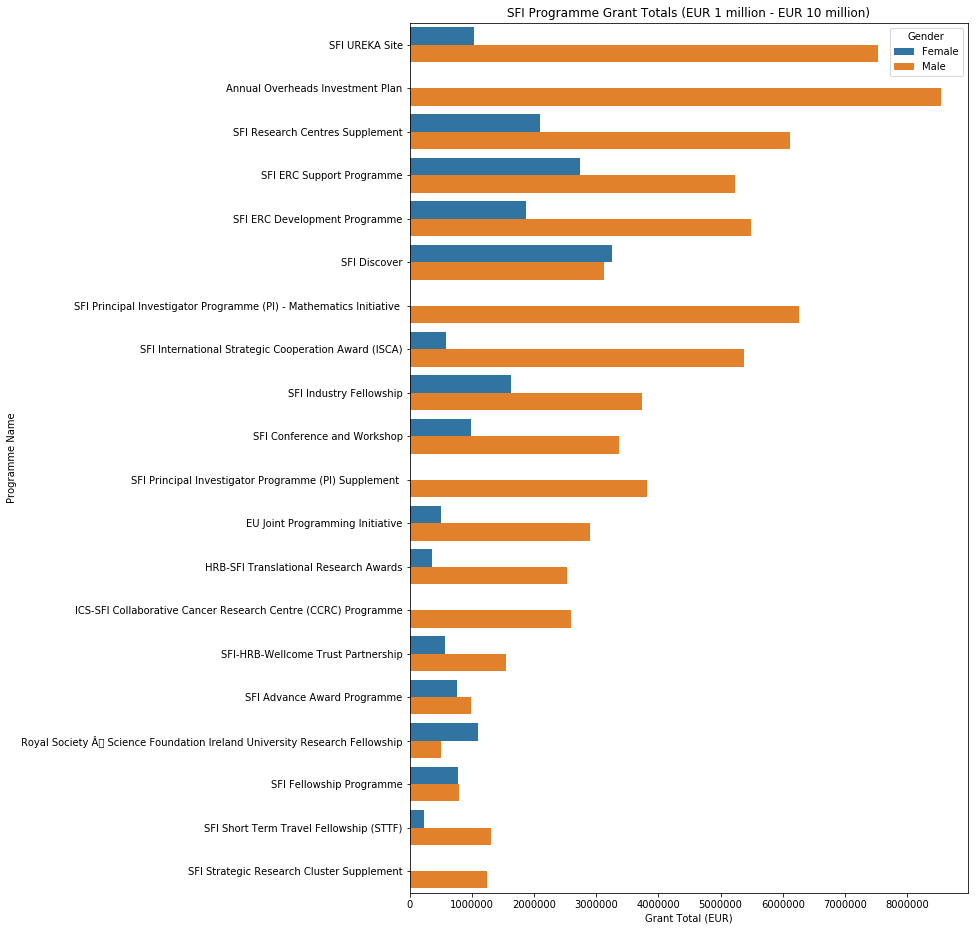

In [44]:
plt.figure(figsize=(10,16))

ax=sns.barplot(x="rtotal", 
               y="Programme Name", 
               hue="Gender", 
               data=pndf[pndf["Programme Name"].isin(sorted_pn[(sorted_pn.rtotal>1e6) & (sorted_pn.rtotal<=10e6)]["Programme Name"])].sort_values(by=["pnkey", "Gender"]))
ax.set_xlabel("Grant Total (EUR)")
ax.set_title("SFI Programme Grant Totals (EUR 1 million - EUR 10 million)");
#plt.savefig('./sfi_programme_totals_1m_10m.png', bbox_inches="tight")

### Next, programmes having aggregated totals up to EUR 1 million

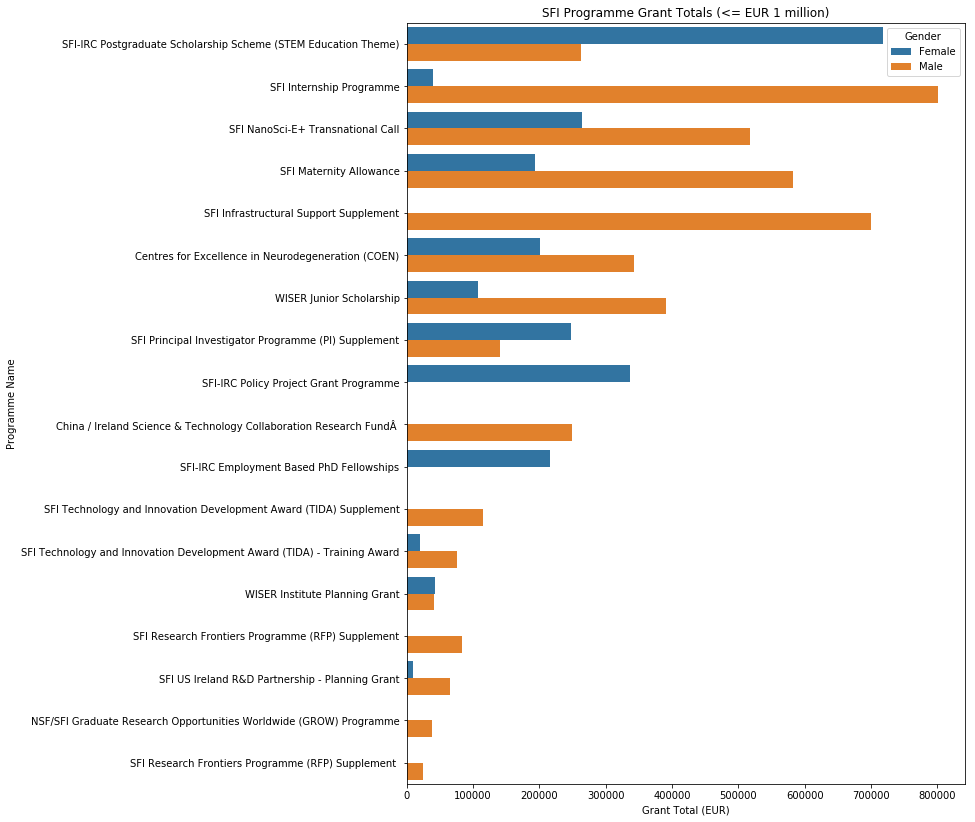

In [45]:
plt.figure(figsize=(10,14))

ax=sns.barplot(x="rtotal", 
               y="Programme Name", 
               hue="Gender", 
               data=pndf[pndf["Programme Name"].isin(sorted_pn[(sorted_pn.rtotal<=1e6)]["Programme Name"])].sort_values(by=["pnkey", "Gender"]))
ax.set_xlabel("Grant Total (EUR)")
ax.set_title("SFI Programme Grant Totals (<= EUR 1 million)");
#plt.savefig('./sfi_programme_totals_le1m.png', bbox_inches="tight")

### Appendix. Retrieving researcher data from SFI Centre websites

Having identified the researcher pages in each website, the corresponding HTML was retrieved and parsed. The vast majority of profiles were identified using an automated process per centre. The following pages and roles were used:

#### ADAPT

* [About -> MEET THE FULL TEAM](https://www.adaptcentre.ie/about/team)
* Roles containing *"academic"*, *"associate"*, *"director"*, "*lecturer*", and "*professor*" were included.

#### AMBER

* [People](http://ambercentre.ie/people/)
* Most researchers have an *Investigator* role, apart from two *Directors* and one *Executive Director*.

#### APC

* [PEOPLE -> APC Faculty](http://apc.ucc.ie/people/apc-faculty/)
* The *Director* and *...Investigator* roles were included.

#### BEACON

* This was not considered as the [PEOPLE] link from the [homepage](http://www.beaconcentre.ie/) was not working as of 2018-10-09 (also checked on 2018-11-12).

#### Confirm

* [People -> Executive Committee](https://confirm.ie/people/?mt-Departments_26_27=Executive+Committee&um_search=1)
* [People -> Principal Investigators](https://confirm.ie/people/?mt-Departments=Principal+Investigator&um_search=1)
* [People -> Funded Investigators](https://confirm.ie/people/?mt-Departments=Funded+Investigator&um_search=1)
* All *Principal Investigators* are on the *Executive Committee*.

#### CONNECT

* [People](https://connectcentre.ie/people/)
* The *...Director* and *...Investigator* roles were included.

#### CURAM

* [ABOUT US -> OUR PEOPLE -> Director](http://www.curamdevices.ie/curam/about-us/our-people/director/professor-abhay-pandit.html)
* [ABOUT US -> OUR PEOPLE -> Co-Directors](http://www.curamdevices.ie/curam/about-us/our-people/co-directors/)
* [ABOUT US -> OUR PEOPLE -> Investigators](http://www.curamdevices.ie/curam/about-us/our-people/investigators/)

#### FutureNeuro

* [PEOPLE](https://www.futureneurocentre.ie/people/)
* The *...Director* and *...Investigator* roles were included.

#### iCRAG

* [PEOPLE -> MEET OUR PEOPLE](http://www.icrag-centre.org/people/)
* The *...Director* and *...Investigator* roles were included.

#### I-Form

* [About Us](http://www.i-form.ie/#About-I-Form)
* [Researchers](http://www.i-form.ie/staff.html)
* The *...Director* and *...Investigator* roles were included.

#### INFANT

* [Who We Are -> Our Team -> Principal Investigators](http://www.infantcentre.ie/who-we-are/our-team/principal-investigators)
* [Who We Are -> Our Team -> Investigators](http://www.infantcentre.ie/who-we-are/our-team/investigator-team)
* The *...Director* and *...Investigator* roles were included.

#### Insight

* [People -> Research Staff](https://www.insight-centre.org/research-staff)
* [People -> Operations Staff](https://www.insight-centre.org/operations-staff)
* The *...Director* and *...Investigator* roles were included, along with those marked as *Alumni*. The *Operations Staff* were also considered due to overlap with the SFI dataset.

#### IPIC

* [WHO WE ARE -> MANAGEMENT OPERATIONS TEAM](http://www.ipic.ie/people/operations-team/)
* [WHO WE ARE -> PRINCIPAL & FUNDED INVESTIGATORS](http://www.ipic.ie/research/our-team/)
* The *...Director* and *...Investigator* roles were included.

#### Lero

* [Meet the Team -> Executive Committee](https://www.lero.ie/aboutlero/managementandgovernance/executive_committee)
* [Meet the Team -> People Directory](https://www.lero.ie/our-people)
* Roles containing *"academic"*, *"director"*, and "*investigator*" were included.

#### MaREI

* [WHO WE ARE -> People](http://www.marei.ie/people/)
* The *...Director* and *...Investigator* roles were included.

#### SSPC

* [ABOUT -> SSPC People -> Principal and Funded Investigators](http://www.sspc.ie/content/sspc_academics)
* The *...Director* and *...Investigator* roles were included.

#### VistaMilk

* [PEOPLE](http://vistamilk.ie/home/people/)
* Only *Director* and *Principal Investigator* roles were listed on 2018-10-12 (verified on 2018-10-25). 
* *Funded Investigators* who were listed on 2018-11-12 have been added.